# Macedonian Stock Exchange

### Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import pickle
import os
%matplotlib inline

Using TensorFlow backend.


### ETL

#### Data Load

In [2]:
# Data Load

df = pd.read_csv('data_mse_mse_historic_data_active.csv', sep='\t')

In [3]:
# Convert to datetime

df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

In [4]:
# sorting  dataframe

df = df.sort_values(by=['stock_id', 'Date'], ascending=[True, False])

#### Stocks to Predict

In [5]:
# Stock to Predict List

STOCKS_TO_PREDICT = ['ALK', 'GRNT', 'KMB', 'MPT' ] # , 'ALK', KMB', 'MPT', 'GRNT', 'TEL', 'STIL', 'STB'

df = df[df['stock_id'].isin(STOCKS_TO_PREDICT)]

In [6]:
df

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,Change %,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,-0.72,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916
1,2020-08-24,ALK,12290.0,12290.0,12289.0,12290.0,73738,12290.0,6,12289.67,0.00,73738,0.885,0.978,0.978,0.944,0.922,0.922,0.922
2,2020-08-21,ALK,12223.0,12290.0,12289.0,12290.0,614476,12290.0,50,12289.52,-0.05,614476,0.885,0.978,0.978,0.944,0.922,0.922,0.922
3,2020-08-20,ALK,12300.0,12300.0,12223.0,12223.0,651640,12223.0,53,12295.09,-0.04,651640,0.885,0.979,0.979,0.945,0.923,0.923,0.923
4,2020-08-19,ALK,12300.0,12300.0,12300.0,12300.0,2952000,12300.0,240,12300.00,0.00,2952000,0.885,0.979,0.979,0.945,0.923,0.923,0.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19843,1998-06-04,MPT,15000.0,15500.0,15000.0,15500.0,6077500,15500.0,401,15155.86,-5.00,6077500,0.087,0.232,0.224,0.199,0.190,0.190,0.190
19844,1998-06-02,MPT,9100.0,15900.0,12000.0,15000.0,2265800,15000.0,158,14340.51,-35.00,2265800,0.082,0.219,0.212,0.188,0.180,0.180,0.180
19845,1998-05-28,MPT,9300.0,10000.0,9100.0,9100.0,1326500,9100.0,143,9276.22,-3.00,1326500,0.053,0.142,0.137,0.122,0.116,0.116,0.116
19846,1998-05-21,MPT,6301.0,9300.0,9001.0,9300.0,780035,9300.0,85,9001.00,-30.00,780035,0.052,0.138,0.133,0.118,0.113,0.113,0.113


#### Lists

In [7]:
# Stock [list]
list_stock_ = list(df['stock_id'].unique())
print(list_stock_)

['ALK', 'GRNT', 'KMB', 'MPT']


### Exploratory Data Analysis

In [8]:
df.shape

(16680, 19)

In [9]:
#pd.set_option('display.max_rows', 100)
df

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,Change %,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,-0.72,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916
1,2020-08-24,ALK,12290.0,12290.0,12289.0,12290.0,73738,12290.0,6,12289.67,0.00,73738,0.885,0.978,0.978,0.944,0.922,0.922,0.922
2,2020-08-21,ALK,12223.0,12290.0,12289.0,12290.0,614476,12290.0,50,12289.52,-0.05,614476,0.885,0.978,0.978,0.944,0.922,0.922,0.922
3,2020-08-20,ALK,12300.0,12300.0,12223.0,12223.0,651640,12223.0,53,12295.09,-0.04,651640,0.885,0.979,0.979,0.945,0.923,0.923,0.923
4,2020-08-19,ALK,12300.0,12300.0,12300.0,12300.0,2952000,12300.0,240,12300.00,0.00,2952000,0.885,0.979,0.979,0.945,0.923,0.923,0.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19843,1998-06-04,MPT,15000.0,15500.0,15000.0,15500.0,6077500,15500.0,401,15155.86,-5.00,6077500,0.087,0.232,0.224,0.199,0.190,0.190,0.190
19844,1998-06-02,MPT,9100.0,15900.0,12000.0,15000.0,2265800,15000.0,158,14340.51,-35.00,2265800,0.082,0.219,0.212,0.188,0.180,0.180,0.180
19845,1998-05-28,MPT,9300.0,10000.0,9100.0,9100.0,1326500,9100.0,143,9276.22,-3.00,1326500,0.053,0.142,0.137,0.122,0.116,0.116,0.116
19846,1998-05-21,MPT,6301.0,9300.0,9001.0,9300.0,780035,9300.0,85,9001.00,-30.00,780035,0.052,0.138,0.133,0.118,0.113,0.113,0.113


In [10]:
# Null check
print('DATA NULL CHECK\n')
df.info()

DATA NULL CHECK

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16680 entries, 0 to 19847
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          16680 non-null  datetime64[ns]
 1   stock_id      16680 non-null  object        
 2   Open          16680 non-null  float64       
 3   High          16680 non-null  float64       
 4   Low           16680 non-null  float64       
 5   Close         16680 non-null  float64       
 6   Volume        16680 non-null  int64         
 7   Adj Close     16680 non-null  float64       
 8   Quantity      16680 non-null  int64         
 9   Average       16680 non-null  float64       
 10  Change %      16676 non-null  float64       
 11  Volume Total  16680 non-null  int64         
 12  Ratio         16680 non-null  float64       
 13  Ratio 1m      16680 non-null  float64       
 14  Ratio 3m      16680 non-null  float64       
 15  Ratio 6m      16680

In [11]:
# Data basic stats

df.describe()

,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,Change %,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y
count,16680.000000,16680.000000,16680.000000,16680.000000,1.668000e+04,16680.000000,16680.000000,16680.000000,16676.000000,1.668000e+04,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000,16680.000000
mean,10945.998321,11012.465827,10875.930695,10950.130995,2.180563e+06,10950.130995,733.616667,10946.255462,0.101039,2.807760e+06,0.305785,0.546259,0.539829,0.471562,0.452996,0.452996,0.452996
std,20033.539153,20174.985269,19870.220546,20037.215961,4.606131e+06,20037.215961,2903.346419,20025.310884,3.540219,1.561041e+07,0.205954,0.392387,0.385677,0.333377,0.314074,0.314074,0.314074
min,50.000000,50.000000,50.000000,50.000000,7.570000e+02,50.000000,1.000000,50.000000,-78.180000,7.570000e+02,0.017000,0.040000,0.040000,0.038000,0.038000,0.038000,0.038000
25%,1750.000000,1750.000000,1730.000000,1750.000000,2.240185e+05,1750.000000,43.000000,1749.887500,-0.650000,2.269585e+05,0.151000,0.315000,0.312000,0.274000,0.267000,0.267000,0.267000
50%,4170.500000,4200.000000,4150.000000,4171.000000,7.122750e+05,4171.000000,213.000000,4172.110000,0.000000,7.261210e+05,0.274000,0.429000,0.426000,0.375000,0.364000,0.364000,0.364000
75%,9950.000000,10000.000000,9891.250000,9950.250000,2.074798e+06,9950.250000,696.000000,9947.505000,0.730000,2.165371e+06,0.381000,0.690000,0.683000,0.621000,0.599250,0.599250,0.599250
max,175000.000000,178000.000000,173999.000000,175000.000000,1.105244e+08,175000.000000,307921.000000,175198.220000,153.000000,1.130877e+09,1.023000,3.043000,3.008000,2.596000,2.386000,2.386000,2.386000


In [12]:
# Number of unique stocks

a = df['stock_id'].nunique()
b = df['stock_id'].unique()

print(f"Number of Unique Stocks: {a}\n\n", f"Unique Stocks: {b}")

Number of Unique Stocks: 4

 Unique Stocks: ['ALK' 'GRNT' 'KMB' 'MPT']


#### Visualization

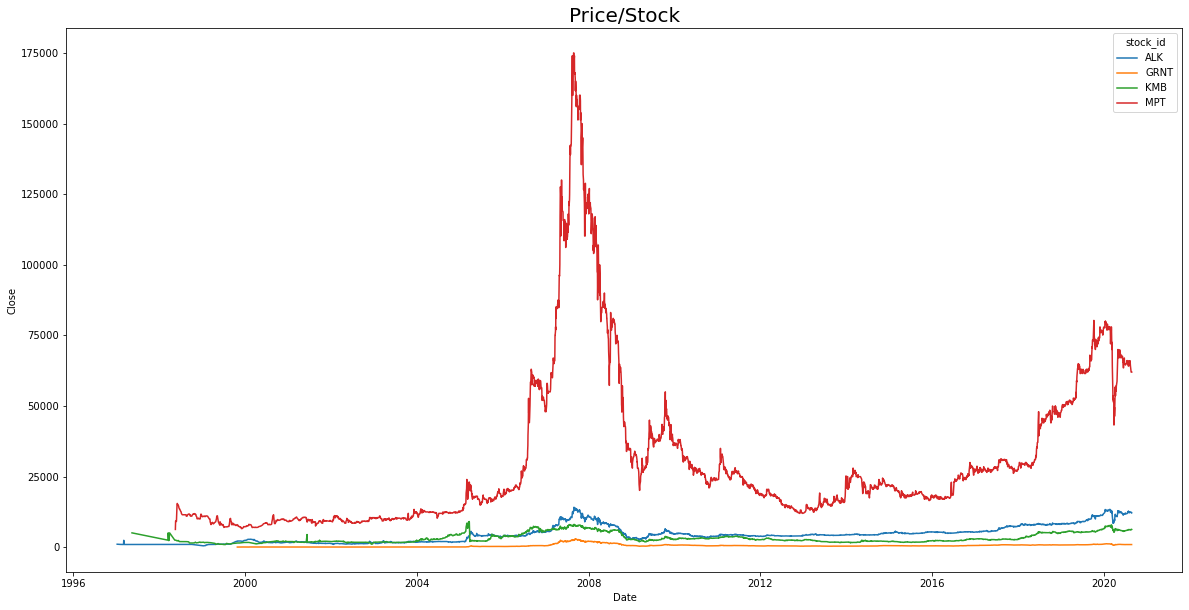

In [13]:
# Timeseries Line Plot of all stock Closing price

fig = plt.figure(figsize = (20,10))
a = sns.lineplot(x = df['Date'], y = df['Close'], hue = df['stock_id'])

a.set_title("Price/Stock", fontsize=20)

plt.show()

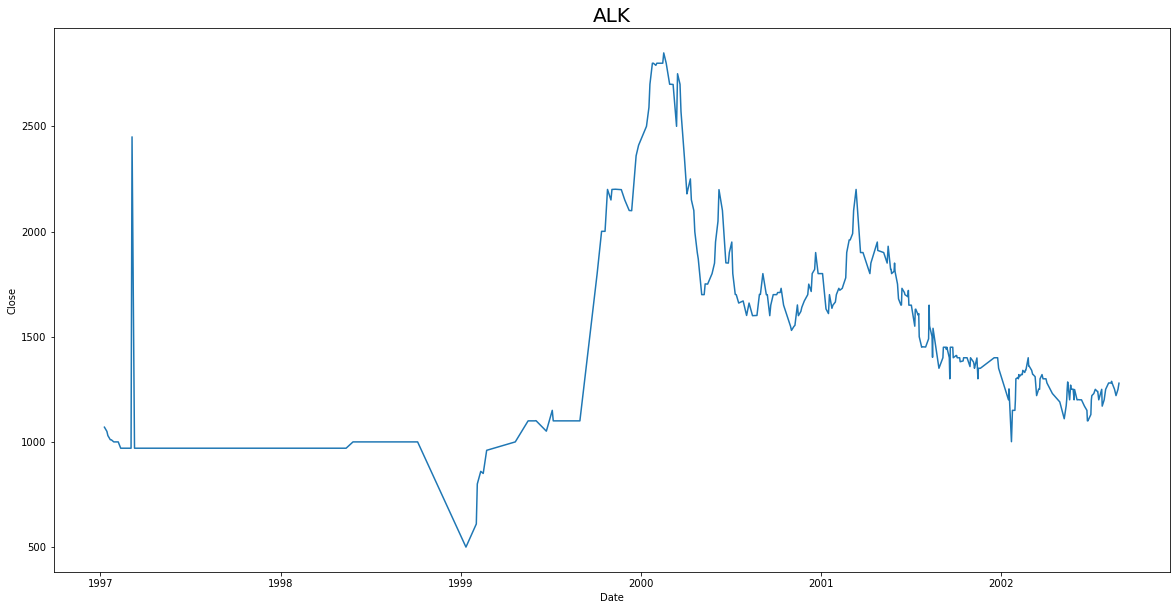

In [14]:
# Timeseries Line Plot of all stock Closing price
alk_data = df[df['stock_id']=='ALK']
alk_data = alk_data.tail(365)

fig = plt.figure(figsize = (20,10))
a = sns.lineplot(x = alk_data['Date'], y = alk_data['Close'])

a.set_title("ALK", fontsize=20)

plt.show()

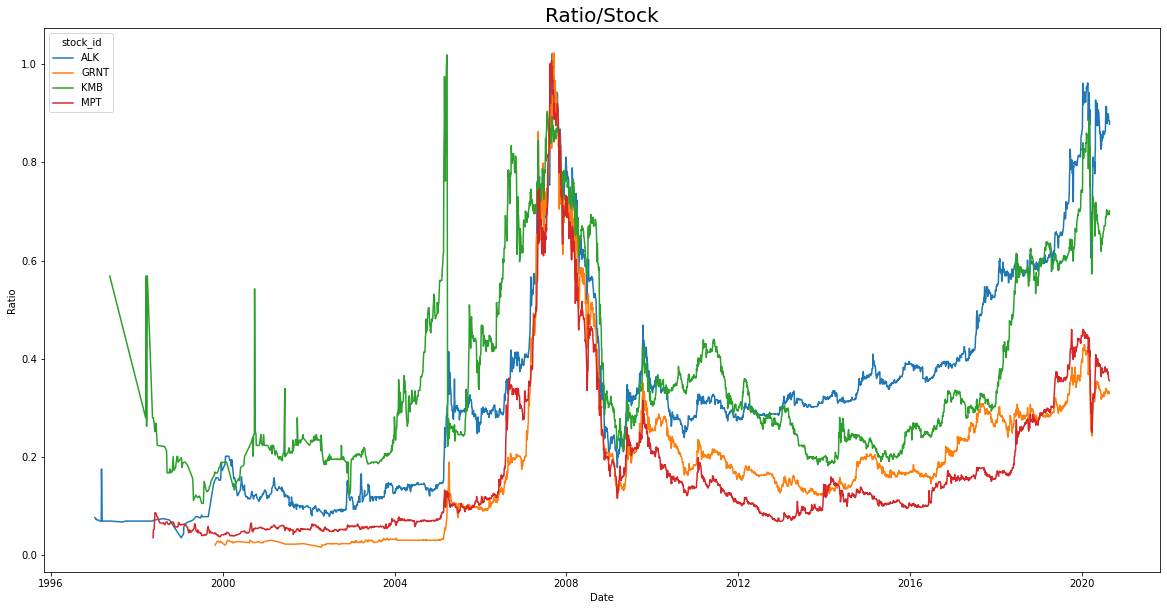

In [15]:
# Timeseries Line Plot of all stock Ratio price

fig = plt.figure(figsize = (20,10))
a = sns.lineplot(x = df['Date'], y = df['Ratio'], hue = df['stock_id'])

a.set_title("Ratio/Stock", fontsize=20)

plt.show()

In [16]:
# Highest price ever

high_price = df[['stock_id','Date','Close']].groupby(['stock_id', 'Date'])['Close'].sum().reset_index().sort_values('Close', ascending=False)
high_price

,stock_id,Date,Close
13912,MPT,2007-08-29,175000.0
13911,MPT,2007-08-27,174999.0
13915,MPT,2007-09-03,173990.0
13904,MPT,2007-08-16,173990.0
13914,MPT,2007-08-31,172000.0
...,...,...,...
4519,GRNT,1999-10-28,61.0
4524,GRNT,2000-01-20,61.0
4553,GRNT,2002-04-23,60.0
4552,GRNT,2002-04-22,50.0


In [17]:
# Latest day of trading

# lates date
latest_date = df['Date'].max()

# last day of trading
b = df[df['Date']==latest_date]
b

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,Change %,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y
0,2020-08-25,ALK,12290.0,12222.0,12200.0,12200.0,3660440,12200.0,300,12201.47,-0.72,3660440,0.878,0.971,0.971,0.937,0.916,0.916,0.916
11465,2020-08-25,KMB,6250.0,6300.0,6250.0,6300.0,771074,6300.0,123,6268.89,0.46,771074,0.702,1.002,1.002,0.802,0.802,0.802,0.802
15681,2020-08-25,MPT,62000.0,62000.0,61800.0,62000.0,2848115,62000.0,46,61915.54,-0.14,2848115,0.356,0.947,0.914,0.812,0.775,0.775,0.775


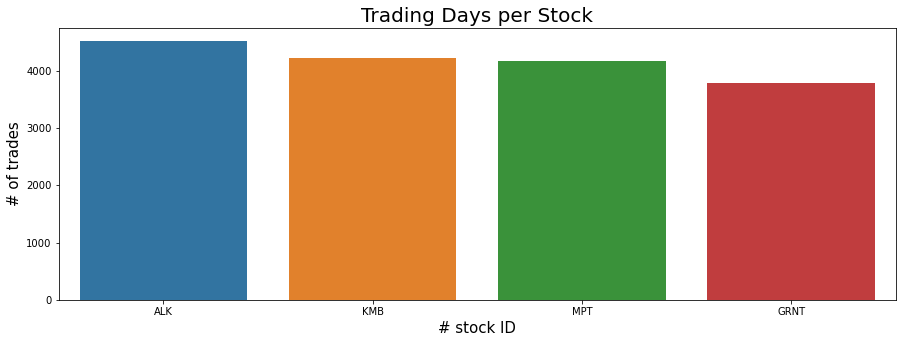

In [18]:
# Trades per Stock

# data
data = df.groupby(['Date', 'stock_id'])['Close'].count().reset_index().sort_values('Date', ascending=True)
data = data.groupby('stock_id')['Close'].sum().reset_index().sort_values('Close', ascending=False)

# plot
plt.figure(figsize = (15,5))
a = sns.barplot(x = data['stock_id'],y = data['Close'])
plt.ylabel('# of trades', size=15)
plt.xlabel('# stock ID', size=15)
plt.title('Trading Days per Stock', size=20)

plt.show()

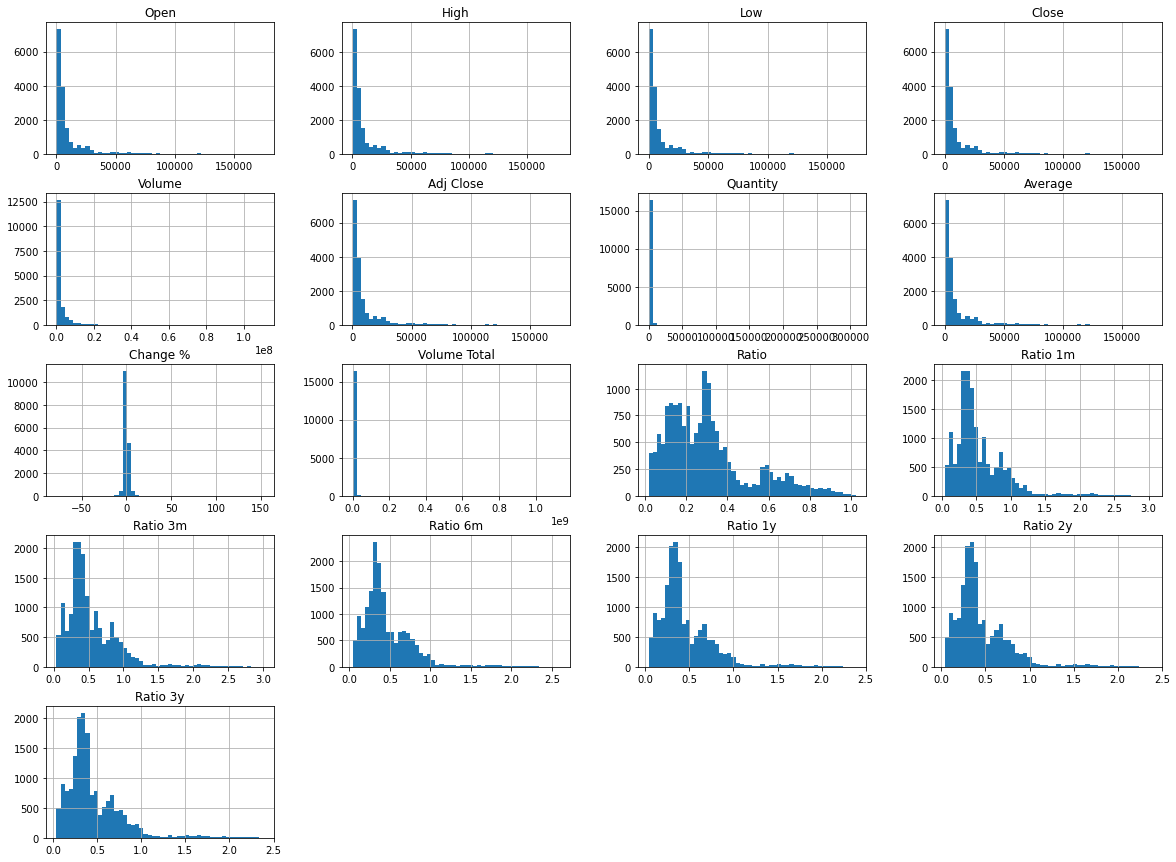

In [19]:
# Histograms (to be made for each stock separately)

df.hist(bins=50, figsize=(20,15))
plt.show()

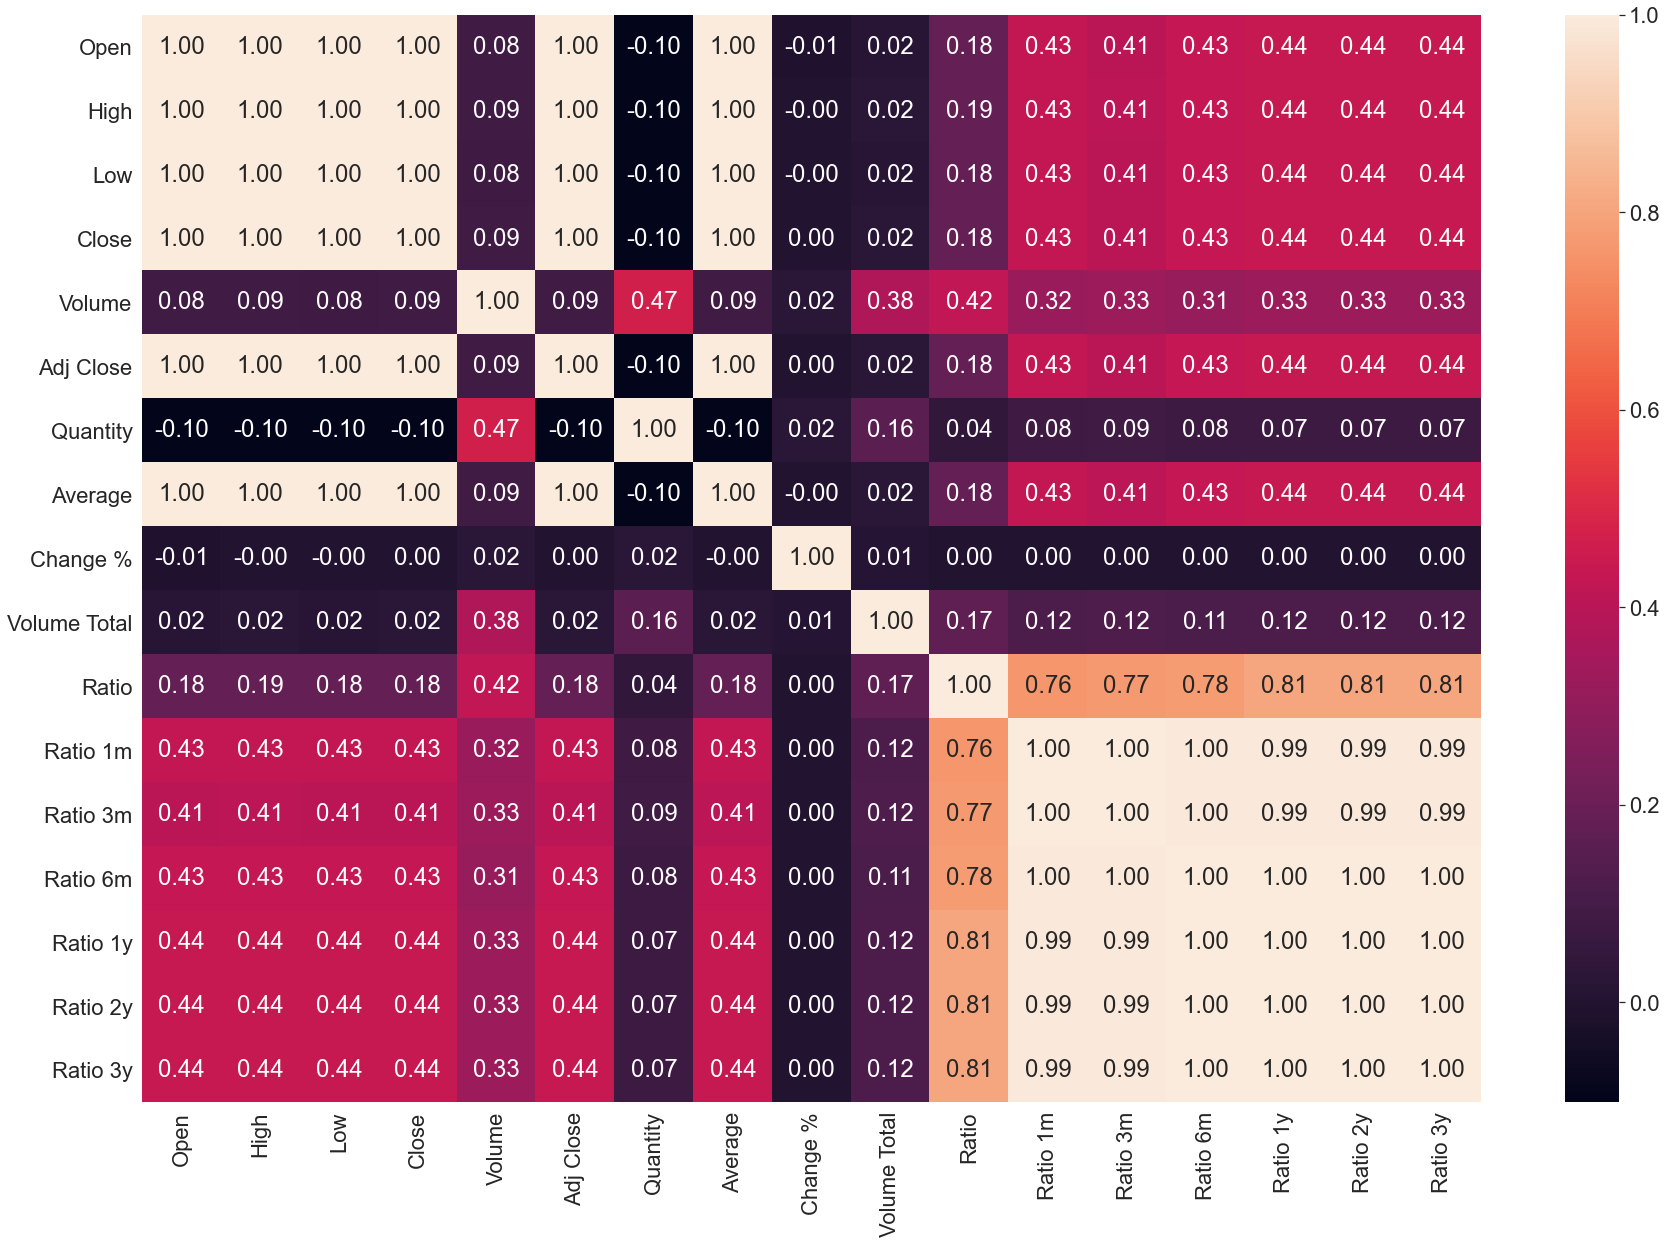

In [20]:
corr_matrix = df.corr()

plt.figure(figsize=(30, 20))
sns.set(font_scale=2)
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

In [21]:
# ADD MORE DATA EXPLORATION and GRAPHS

In [22]:
# USE DATA EXPLORATION TO DESIGN TRADING STRATEGY and CHOOSE STOCKS TO BE OF MAIN FOCUS(???)

### ETL for Machine Learning

In [23]:
# Function: Basic transform

def frame_basic_tranform(dataframe):
    # Change % column 0s fill
    dataframe['Change %'] = dataframe['Change %'].fillna(0)
    # Adding Block Volume column
    dataframe['Volume Block'] = dataframe['Volume Total'] - dataframe['Volume']
    return dataframe

In [24]:
# Basic transformation
df = frame_basic_tranform(df)

In [25]:
# Function to create dataframe with all trade dates for each stock in dataset and adding Day_id

def all_trading_days(dataframe):
    #add Day_id
    min_date_global = dataframe['Date'].min()
    max_date_global = dataframe['Date'].max()
    date_range_df = pd.date_range(min_date_global, max_date_global, freq='d').to_frame(index=False, name='Date')
    date_range_df.reset_index(inplace=True)
    date_range_df.rename(columns={'index':'Day_id'}, inplace=True)
    
    # empty data fram
    aug_df = pd.DataFrame(columns=dataframe.columns)
    # function to be finished
    for stock in list_stock_:
        # original df for each stock
        stock_df = df[df['stock_id']==stock]    
        # min and max trading dates for each stock
        min_date = stock_df['Date'].min()
        max_date = df['Date'].max()
        # a data frame for each stock with all the dates of trade 
        temp_df = pd.date_range(min_date, max_date, freq='d').to_frame(index=False, name='Date') 
        temp_df['stock_id'] = stock    
        # merge temp_df and origrinal df
        temp_df = pd.merge(temp_df, stock_df, on=['Date', 'stock_id'], how='left')    
        # concateante each temp_df to aug_df
        aug_df = aug_df.append(temp_df)

    aug_df_merge = pd.merge(aug_df, date_range_df, how='left', on='Date')
        
    return aug_df_merge

In [26]:
# All trading days dataframe

aug_df = all_trading_days(df)

In [27]:
aug_df

,Date,stock_id,Open,High,Low,Close,Volume,Adj Close,Quantity,Average,...,Volume Total,Ratio,Ratio 1m,Ratio 3m,Ratio 6m,Ratio 1y,Ratio 2y,Ratio 3y,Volume Block,Day_id
0,1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.00,...,279270.0,0.077,0.085,0.085,0.082,0.080,0.080,0.080,0.0,0
1,1997-01-10,ALK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1997-01-11,ALK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,1997-01-12,ALK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1997-01-13,ALK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32872,2020-08-21,MPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8625
32873,2020-08-22,MPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8626
32874,2020-08-23,MPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8627
32875,2020-08-24,MPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8628


In [28]:
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32877 entries, 0 to 32876
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          32877 non-null  datetime64[ns]
 1   stock_id      32877 non-null  object        
 2   Open          16680 non-null  float64       
 3   High          16680 non-null  float64       
 4   Low           16680 non-null  float64       
 5   Close         16680 non-null  float64       
 6   Volume        16680 non-null  float64       
 7   Adj Close     16680 non-null  float64       
 8   Quantity      16680 non-null  float64       
 9   Average       16680 non-null  float64       
 10  Change %      16680 non-null  float64       
 11  Volume Total  16680 non-null  float64       
 12  Ratio         16680 non-null  float64       
 13  Ratio 1m      16680 non-null  float64       
 14  Ratio 3m      16680 non-null  float64       
 15  Ratio 6m      16680 non-null  float6

In [29]:
# Fill of missing values function

def fill_of_missing_values(dataframe):
    # fill in Volume, Quantity, and Volume Total columns with $0s
    dataframe['Volume'] = dataframe['Volume'].fillna(0)
    dataframe['Quantity'] = dataframe['Quantity'].fillna(0)
    dataframe['Volume Block'] = dataframe['Volume Block'].fillna(0)
    # fill the rest of the columns with forward will method
    dataframe = dataframe.fillna(method='ffill')
    return dataframe

In [30]:
# Dataframe with no missing values 
df = fill_of_missing_values(aug_df)

### Feature Engineering

In [31]:
# Time features function

def time_features_add(dataframe):
    dataframe['day'] = dataframe['Date'].dt.day.astype(float)
    dataframe['month'] = dataframe['Date'].dt.month.astype(float)
    dataframe['year'] = dataframe['Date'].dt.year.astype(float)
    dataframe['dayofyear'] = dataframe['Date'].dt.dayofyear.astype(float)
    dataframe['weekday'] = np.where(dataframe['Date'].dt.dayofweek < 5, 1, 0).astype(float)
    
    return dataframe

In [32]:
#df = time_features_add(df)

In [33]:
# Feature Engineering (to be added more)

def base_features_add(dataframe):
    # adding volatility column
    dataframe['Volatility'] = dataframe['High'] - dataframe['Low'] 
    dataframe['Volatility'] = np.where(dataframe['Quantity'] == 0, dataframe['Volatility'] * 0, dataframe['Volatility'])
    return dataframe

In [34]:
df = base_features_add(df)

In [35]:
# Drop columns function 
def drop_features(drop_columns_list, dataframe):    
    dataframe = dataframe.drop(drop_columns_list, axis=1)
    return dataframe

In [36]:
# drop correlated features to target feature

CORRELATED_TO_DEPENDENT_FEATURE = ['Adj Close', 'Average', 'High', 'Low', 'Open', 'Volume Total', 'Quantity'] #'Volume Block'

df = drop_features(CORRELATED_TO_DEPENDENT_FEATURE, df)

In [37]:
# drop correlated features columns

CORRELATED_INDEPENDENT_FEATURES = ['Ratio 1y', 'Ratio 2y', 'Ratio 3y','Ratio 1m', 'Ratio 6m', 'Ratio'] #'Ratio', 'Ratio 3m'

df = drop_features(CORRELATED_INDEPENDENT_FEATURES, df)

In [38]:
df

,Date,stock_id,Close,Volume,Change %,Volume Block,Day_id,Volatility
0,1997-01-09,ALK,1070.0,279270.0,0.00,0.0,0,0.0
1,1997-01-10,ALK,1070.0,0.0,0.00,0.0,1,0.0
2,1997-01-11,ALK,1070.0,0.0,0.00,0.0,2,0.0
3,1997-01-12,ALK,1070.0,0.0,0.00,0.0,3,0.0
4,1997-01-13,ALK,1070.0,0.0,0.00,0.0,4,0.0
...,...,...,...,...,...,...,...,...
32872,2020-08-21,MPT,62000.0,0.0,-3.43,0.0,8625,0.0
32873,2020-08-22,MPT,62000.0,0.0,-3.43,0.0,8626,0.0
32874,2020-08-23,MPT,62000.0,0.0,-3.43,0.0,8627,0.0
32875,2020-08-24,MPT,62000.0,0.0,-3.43,0.0,8628,0.0


#### Categorical Encoding

In [39]:
# Categorical features encoding function

def categorical_encoding(dataframe, categorical_list):
    # encoder 
    encoder = LabelEncoder()
    # transform to categorical
    categorical_array = encoder.fit_transform(dataframe[categorical_list])
    # to dataframe
    categorical_df = pd.DataFrame(categorical_array, columns=categorical_list).reset_index() 
    # return encoded to dataframe
    dataframe[categorical_list] = categorical_df[categorical_list].values
    return dataframe

In [40]:
# Categorical Encoding

# categorical list assumption
CATEGORICAL_FEATURES = ['stock_id']

df = categorical_encoding(df, CATEGORICAL_FEATURES)

C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


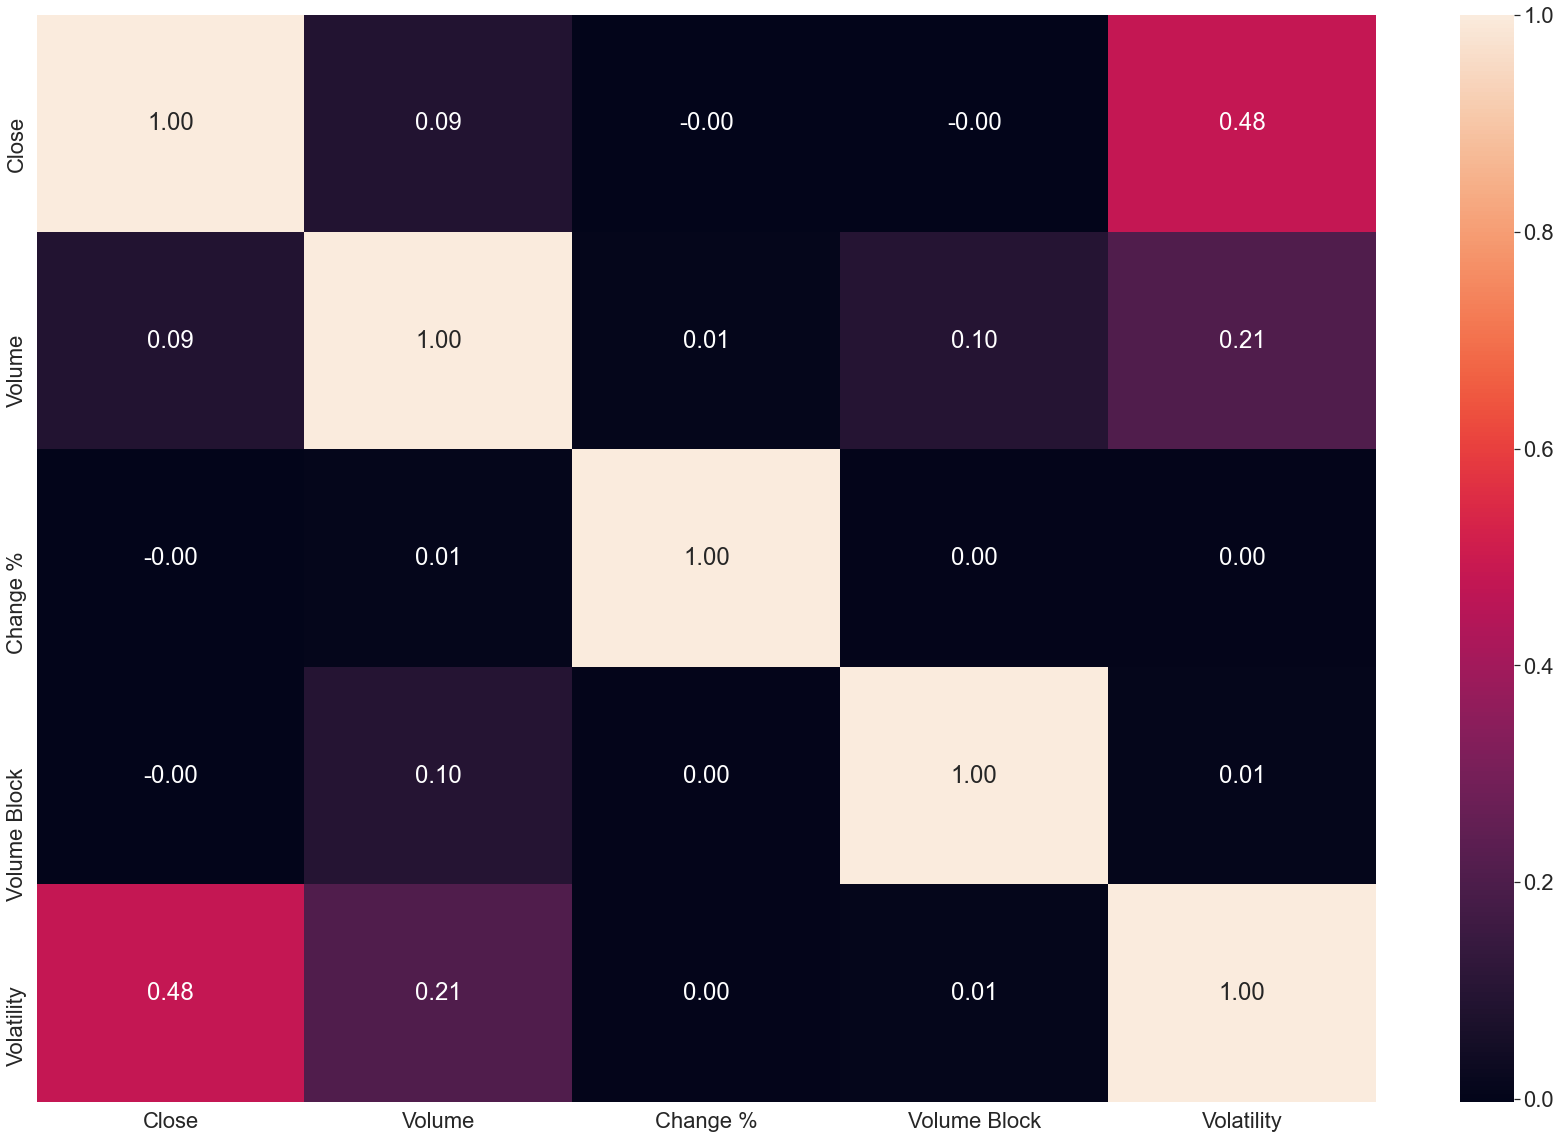

In [41]:
# Correlation matrix
corr_df = df.loc[:,[col for col in df.columns if col not in ['stock_id', 'Day_id']]]
corr_matrix = corr_df.corr()

plt.figure(figsize=(30, 20))
sns.set(font_scale=2)
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.show()

In [42]:
# Latest close price per stock and lates trading day

days_lost_due_to_split = timedelta(days=0)
days_lost_due_to_split

df_latest_day = df[df['Date']==latest_date-days_lost_due_to_split]
latest_close = df_latest_day[['Date', 'stock_id','Close']].reset_index(drop=True)
latest_close

,Date,stock_id,Close
0,2020-08-25,0,12200.0
1,2020-08-25,1,950.0
2,2020-08-25,2,6300.0
3,2020-08-25,3,62000.0


In [43]:
df[df['stock_id']==0]

,Date,stock_id,Close,Volume,Change %,Volume Block,Day_id,Volatility
0,1997-01-09,0,1070.0,279270.0,0.00,0.0,0,0.0
1,1997-01-10,0,1070.0,0.0,0.00,0.0,1,0.0
2,1997-01-11,0,1070.0,0.0,0.00,0.0,2,0.0
3,1997-01-12,0,1070.0,0.0,0.00,0.0,3,0.0
4,1997-01-13,0,1070.0,0.0,0.00,0.0,4,0.0
...,...,...,...,...,...,...,...,...
8625,2020-08-21,0,12290.0,614476.0,-0.05,0.0,8625,1.0
8626,2020-08-22,0,12290.0,0.0,-0.05,0.0,8626,0.0
8627,2020-08-23,0,12290.0,0.0,-0.05,0.0,8627,0.0
8628,2020-08-24,0,12290.0,73738.0,0.00,0.0,8628,1.0


##### Tsfresh feature extraction

In [44]:
# dataframe to add features on
df_in = df

In [45]:
# Function to Load data for tsfresh feature extractions

def tsfresh_features_dataframe(dataframe):
    df_in = dataframe
    df_in.drop(['Date'], axis=1, inplace=True)
    
    dataframe_list = []
    
    for stock in range(len(list_stock_)):
        # filter each stock
        stock_df = df_in[df_in['stock_id']==stock]
        
        # rolling of dataframe
        df_rolled = roll_time_series(stock_df,
                                     column_id='stock_id',
                                     column_sort='Day_id',
                                     min_timeshift = 3,
                                     show_warnings=True,
                                     max_timeshift = 3)
        df_rolled.drop(['stock_id'], axis=1, inplace=True)
        
        # extracting of best features
        extracted_features = extract_features(df_rolled, 
                                              column_id='id', 
                                              column_sort='Day_id')
        
        print(extracted_features)
        
        # making of y to filter features against
        y = stock_df.iloc[3:,:] # need to make 3s into an input assumptions for days_of_rolling
        stock_y_ids = [stock for x in range(0,len(y))]
        stock_y_2nd_ids = extracted_features.index.get_level_values(1).to_list()
        tuples = list(zip(stock_y_ids, stock_y_2nd_ids))
        index_ = pd.MultiIndex.from_tuples(tuples, names=['stock', 'day'])
        y = pd.Series(data=y['Close'].values, index=index_)
        
        print(y)
        
        # features filtering
        impute(extracted_features)
        features_filtered = select_features(extracted_features, y)
        dataframe_list.append(features_filtered)
        
    return dataframe_list

In [ ]:
# extract tsfresh features
tsfresh_dataframe_list = tsfresh_features_dataframe(df_in)

In [ ]:
tsfresh_dataframe_list[0].columns

In [46]:
# Function to save dataframes list into a pickle object
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [128]:
# Save dataframe list to pickle object
save_object(tsfresh_dataframe_list, 'tsfresh_dataframes_list.pkl')

NameError: name 'tsfresh_dataframe_list' is not defined

##### Read saved dataframes list

In [555]:
# Read pickle object
file_to_read = open("tsfresh_dataframes_list.pkl", "rb")

loaded_object = pickle.load(file_to_read)

file_to_read.close()
print(loaded_object)

[        Close__lempel_ziv_complexity__bins_100  \
0 3                                       0.50   
  4                                       0.50   
  5                                       0.75   
  6                                       0.75   
  7                                       0.75   
...                                        ...   
  8625                                    0.75   
  8626                                    0.75   
  8627                                    0.75   
  8628                                    0.50   
  8629                                    0.75   

        Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0 3                                            576.030998               
  4                                            576.030998               
  5                                            576.030998               
  6                                            576.030998               
  7                              

In [556]:
# Function to add old columns to calculated tsfresh features
def merge_to_basic_features(dfs_list, df_basic):
    # list of merged tsfresh and original dfs
    merged_tsfresh_dfs_list = []
    
    for stock in range(len(list_stock_)):
        # tsfresh df
        stock_frame = dfs_list[stock].reset_index().rename(columns={'level_0':'stock_id',
                                  'level_1':'Day_id'}, 
                         inplace=False)
        # original df
        stock_original_frame = df_basic[df_basic['stock_id']==stock]
        
        # merge tsfresh and original dfs
        stock_merged = stock_frame.merge(stock_original_frame, on='Day_id')
        stock_merged.drop(['stock_id_x', 'Date'], axis=1, inplace=True)
        stock_merged.rename(columns={'stock_id_y':'stock_id'}, inplace=True)
        merged_tsfresh_dfs_list.append(stock_merged)
        
    return merged_tsfresh_dfs_list

In [557]:
# Merging tsfresh and basic features
tsfresh_dfs_list = merge_to_basic_features(loaded_object, df)
tsfresh_dfs_list[1]

,Day_id,Close__sum_values,"Volume__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)","Volume__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","Volume__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","Volume__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","Volume__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)","Volume__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)",Volume__spkt_welch_density__coeff_2,Volatility__quantile__q_0.4,...,"Volume Block__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Volume Block__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",Change %__autocorrelation__lag_1,Volatility__friedrich_coefficients__coeff_0__m_3__r_30,stock_id,Close,Volume,Change %,Volume Block,Volatility
0,1025,244.0,4350.057207,3155.569582,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,0.0,-0.111111,0.00027,1,61.0,0.0,0.00,0.0,0.0
1,1026,244.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,0.0,-0.111111,0.00027,1,61.0,0.0,0.00,0.0,0.0
2,1027,244.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,0.0,-0.111111,0.00027,1,61.0,0.0,0.00,0.0,0.0
3,1028,244.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,0.0,-0.111111,0.00027,1,61.0,0.0,0.00,0.0,0.0
4,1029,244.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,0.0,-0.111111,0.00027,1,61.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7600,8625,3836.0,384912.611098,276851.475301,611564.721571,524810.624120,387950.332314,277392.684820,3.435022e+11,0.0,...,0.0,0.0,-0.111111,0.00027,1,959.0,904337.0,0.00,0.0,0.0
7601,8626,3836.0,387950.332314,277392.684820,503960.822483,345534.105304,247105.400081,175222.537885,5.452169e+11,0.0,...,0.0,0.0,-0.111111,0.00027,1,959.0,0.0,0.00,0.0,0.0
7602,8627,3836.0,247105.400081,175222.537885,183159.705487,305158.406577,239741.464073,173910.556967,1.363042e+11,0.0,...,0.0,0.0,-0.111111,0.00027,1,959.0,0.0,0.00,0.0,0.0
7603,8628,3827.0,277518.485946,201314.339371,79411.123512,54447.191706,38937.386739,27610.516487,3.384375e+09,0.0,...,0.0,0.0,-0.111111,0.00027,1,950.0,142500.0,-0.94,0.0,0.0


In [558]:
# Function select K best
def select_K_Best(dfs_tfs_list, nr_best_features=100):
    # list of best features dfs
    best_dfs_list = []
    
    
    for stock in range(len(list_stock_)):
        stock_frame = dfs_tfs_list[stock]
        
        # y to select against
        y_select = stock_frame['Close'].copy()
        stock_frame.drop('Close', axis=1, inplace=True)
        stock_frame.drop('stock_id', axis=1, inplace=True)
        
        # seect k_best
        k_best = SelectKBest(score_func=f_regression, k=nr_best_features)
        fit = k_best.fit(stock_frame, y_select)
        stock_frame_best30 = fit.transform(stock_frame)
        #important columns indices 
        cols = k_best.get_support(indices=True)
        
        # take only best 
        stock_frame_temp = stock_frame.iloc[:, cols]
        
        # add back Close and stock_id columns
        stock_frame_temp['Close'] = y_select.values
        stock_frame_temp['stock_id'] = stock
        stock_frame_temp.astype('float', copy=True, errors='raise')       
        best_dfs_list.append(stock_frame_temp)
            
    return best_dfs_list

In [559]:
best100_dfs_list = select_K_Best(tsfresh_dfs_list)

C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [560]:
best100_dfs_list[2]

,Close__sum_values,Volume__sum_values,Volume__median,Volume__mean,Volume__standard_deviation,Volume__absolute_sum_of_changes,"Volatility__fft_coefficient__attr_""real""__coeff_0","Volatility__fft_coefficient__attr_""abs""__coeff_0",Volume__maximum,Volatility__value_count__value_0,...,Close__sum_of_reoccurring_values,Close__abs_energy,Close__sum_of_reoccurring_data_points,Close__maximum,Volatility__quantile__q_0.8,Close__benford_correlation,Close__max_langevin_fixed_point__m_3__r_30,Volatility__symmetry_looking__r_0.25,Close,stock_id
0,20340.0,50850.0,0.0,12712.50,2.201870e+04,50850.0,0.0,0.0,50850.0,4.0,...,5085.0,103428900.0,20340.0,5085.0,0.0,-0.145280,3402.000000,0.0,5085.0,2
1,20340.0,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0,0.0,4.0,...,5085.0,103428900.0,20340.0,5085.0,0.0,-0.145280,3402.000000,0.0,5085.0,2
2,20340.0,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0,0.0,4.0,...,5085.0,103428900.0,20340.0,5085.0,0.0,-0.145280,3402.000000,0.0,5085.0,2
3,20340.0,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0,0.0,4.0,...,5085.0,103428900.0,20340.0,5085.0,0.0,-0.145280,3402.000000,0.0,5085.0,2
4,20340.0,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0,0.0,4.0,...,5085.0,103428900.0,20340.0,5085.0,0.0,-0.145280,3402.000000,0.0,5085.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8496,24943.0,15373970.0,3703570.0,3843492.50,3.427707e+06,8854622.0,119.0,119.0,7731154.0,1.0,...,0.0,155539857.0,0.0,6250.0,44.0,-0.200946,6247.756614,1.0,6243.0,2
8497,24936.0,14738567.0,3503706.5,3684641.75,3.583866e+06,15226632.0,79.0,79.0,7731154.0,2.0,...,6243.0,155452406.0,12486.0,6248.0,37.4,-0.200946,6612.857455,1.0,6243.0,2
8498,24977.0,14502891.0,3385868.5,3625722.75,3.641555e+06,7731154.0,79.0,79.0,7731154.0,2.0,...,6243.0,155962651.0,18729.0,6248.0,37.4,-0.200946,3402.000000,1.0,6243.0,2
8499,24979.0,27126317.0,3385868.5,6781579.25,8.309724e+06,27126317.0,79.0,79.0,20354580.0,2.0,...,6243.0,155987647.0,18729.0,6250.0,37.4,-0.200946,3402.000000,1.0,6250.0,2


### Dataset Split into Train & Test

In [561]:
# dataframe to split

STOCK_IDX = 0

split_df = best100_dfs_list[STOCK_IDX]

In [562]:
split_df

,Day_id,"Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)","Close__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)",...,"Volume__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)",Volume__count_below__t_0,"Volume__fft_coefficient__attr_""real""__coeff_0",Volume__range_count__max_1__min_-1,Volume__value_count__value_0,Change %__percentage_of_reoccurring_values_to_all_values,"Volume__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)",Close__max_langevin_fixed_point__m_3__r_30,Close,stock_id
0,3,576.030998,413.089823,1409.272257,1178.722623,868.402955,620.410894,1625.984484,1539.782156,1152.061996,...,7.403501e+04,0.75,279270.0,3.0,3.0,1.000000,9.423654e+04,4983.616963,1070.0,0
1,4,576.030998,413.089823,1409.272257,1178.722623,868.402955,620.410894,1625.984484,1539.782156,1152.061996,...,0.000000e+00,1.00,0.0,4.0,4.0,1.000000,0.000000e+00,4983.616963,1070.0,0
2,5,576.030998,413.089823,1409.272257,1178.722623,868.402955,620.410894,1621.933788,1533.033379,1146.759958,...,1.003066e+05,0.75,378370.0,3.0,3.0,0.500000,1.276767e+05,4983.616963,1050.0,0
3,6,576.030998,413.089823,1405.221561,1171.973846,863.100916,616.564750,1610.788367,1525.391668,1141.295061,...,1.033876e+05,0.75,378370.0,3.0,3.0,1.000000,1.445697e+05,4983.616963,1050.0,0
4,7,570.728960,409.243678,1394.076140,1164.332135,857.636020,612.689589,1595.592250,1511.001181,1130.528127,...,1.686478e+05,0.50,624540.0,2.0,2.0,0.333333,2.276370e+05,4983.616963,1030.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8622,8625,6621.664743,4748.602641,16184.450391,13523.819322,9962.163173,7117.018512,18646.288284,17667.504572,13219.638617,...,1.558430e+06,0.00,5767916.0,0.0,0.0,0.000000,2.107210e+06,4983.616963,12290.0,0
8623,8626,6601.251897,4733.794983,16155.110352,13517.007135,9958.885150,7114.983730,18640.715573,17663.683716,13216.906169,...,1.128540e+06,0.25,4218116.0,1.0,1.0,0.333333,1.479884e+06,12290.000000,12290.0,0
8624,8627,6597.973873,4731.760202,16149.537641,13513.186279,9956.152702,7113.046150,18662.457554,17663.300660,13214.800725,...,3.406534e+05,0.50,1266116.0,2.0,2.0,0.500000,4.546710e+05,4983.616963,12290.0,0
8625,8628,6616.281276,4744.741989,16186.874801,13538.786011,9974.460104,7126.027937,18676.027385,17685.909060,13232.562552,...,1.824468e+05,0.50,688214.0,2.0,2.0,0.500000,2.322301e+05,4983.616963,12290.0,0


In [563]:
# Train and Test split function and dropping of Date column

def split_test_train(dataframe, days_in_test):
    # last # of days to split into test
    # train and test dataframes
    train = pd.DataFrame(columns=dataframe.columns)
    test = pd.DataFrame(columns=dataframe.columns)
    # split
    for stock in range(1):
        # original df for each stock
        stock_df = dataframe[dataframe['stock_id']==STOCK_IDX]
        
        #train
        train_df = stock_df.iloc[:-days_in_test]
        # concateante each train_df to train
        train = train.append(train_df)
                
        #test
        test_df = stock_df.tail(days_in_test)
        # concateante each train_df to train
        test = test.append(test_df)
    
    return train, test

In [564]:
# Split in train test

# days in test assumption
DAYS_IN_TEST = 77

# split
train, test = split_test_train(split_df, DAYS_IN_TEST)

In [565]:
train.shape, test.shape

((8550, 102), (77, 102))

In [566]:
#pd.set_option('display.max_rows', None)
#test

### Preparing Data for Time Series Regression

#### Series to supervised (leads and lags)

In [567]:
# Function that segments a series data input into leads and lags feature columns

def series_to_supervised(data, columns, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns = columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s_Lag(t-%d)' % (name, i)) for j, name in enumerate(columns)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s_Lead(t)' % (name)) for j, name in enumerate(columns)]
        else:
            names += [('%s_Lead(t+%d)' % (name, i)) for j, name in enumerate(columns)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [568]:
# Prepare train and test data sets into supervised function

def trainTest_to_supervised(dataframe, n_in, n_out):
    # number of variables
    n_vars_ = dataframe.shape[1]
    # empty dataframe
    train_test_dataframe = pd.DataFrame(columns=np.arange((n_in*n_vars_)+(n_out*n_vars_)))
    # adding features
    for stock in range(1):     
        # original df for each stock
        train_df = dataframe[dataframe['stock_id']==STOCK_IDX]
        # data for series_to_supervised
        train_values = train_df.values
        column_names = train_df.columns
        train_tsr =  series_to_supervised(train_values, column_names, n_in, n_out)
        train_test_dataframe.columns = train_tsr.columns
        train_test_dataframe = train_test_dataframe.append(train_tsr)
        
    return train_test_dataframe

In [569]:
# Train and Test to Supervised

# base assumptions
N_STEPS_IN = 40 #lookback
N_STEPS_OUT = 7 #lookforward

# split
train_super = trainTest_to_supervised(train, n_in=N_STEPS_IN, n_out=N_STEPS_OUT)
test_super = trainTest_to_supervised(test, n_in=N_STEPS_IN, n_out=N_STEPS_OUT)

In [570]:
train_super

,Day_id_Lag(t-40),"Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-40)",...,"Volume__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lead(t+6)",Volume__count_below__t_0_Lead(t+6),"Volume__fft_coefficient__attr_""real""__coeff_0_Lead(t+6)",Volume__range_count__max_1__min_-1_Lead(t+6),Volume__value_count__value_0_Lead(t+6),Change %__percentage_of_reoccurring_values_to_all_values_Lead(t+6),"Volume__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)_Lead(t+6)",Close__max_langevin_fixed_point__m_3__r_30_Lead(t+6),Close_Lead(t+6),stock_id_Lead(t+6)
40,3,576.031,413.09,1409.27,1178.72,868.403,620.411,1625.98,1539.78,1152.06,...,154258,0.75,564540,3,3,1,215703,4983.62,970,0
41,4,576.031,413.09,1409.27,1178.72,868.403,620.411,1625.98,1539.78,1152.06,...,149661,0.75,564540,3,3,1,190498,4983.62,970,0
42,5,576.031,413.09,1409.27,1178.72,868.403,620.411,1621.93,1533.03,1146.76,...,0,1,0,4,4,1,0,4983.62,970,0
43,6,576.031,413.09,1405.22,1171.97,863.101,616.565,1610.79,1525.39,1141.3,...,0,1,0,4,4,1,0,4983.62,970,0
44,7,570.729,409.244,1394.08,1164.33,857.636,612.69,1595.59,1511,1130.53,...,0,1,0,4,4,1,0,4983.62,970,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,8502,5975.65,4285.32,14619.6,12227.9,9008.67,6436.04,16867.7,15973.4,11951.3,...,4.1321e+06,0.25,1.54067e+07,1,1,0.333333,5.46059e+06,4983.62,11999,0
8540,8503,5975.65,4285.32,14619.6,12227.9,9008.67,6436.04,16874.8,15985.3,11960.6,...,1.59849e+06,0.5,5.86284e+06,2,2,0.5,2.2209e+06,4983.62,11999,0
8541,8504,5975.65,4285.32,14626.6,12239.7,9017.94,6442.77,16826.4,15885.6,11881.3,...,1.4402e+06,0.75,5.43264e+06,3,3,1,1.83318e+06,4983.62,11999,0
8542,8505,5984.93,4292.06,14578.3,12140,8938.7,6385.13,16699.8,15838.4,11852.4,...,224647,0.75,847400,3,3,0.5,285946,4983.62,11950,0


#### X, y Split

In [571]:
# X, y split function

def X_y_split(dataframe, target_column_list, current_column_list):
    # calculalation of the columns that are in the future and can not be used
    future_columns = [col for col in dataframe.columns if 'Lead' in col]
    # stock_id lags columns drop
    take_away_columns = [col for col in dataframe.columns if 'stock_id' in col]
    # columns to inlude in X train
    a = set(dataframe.columns) - set(target_column_list) - set(future_columns) - set(take_away_columns)
    b = set(current_column_list)
    x_columns = list(a|b)
    
    return dataframe[x_columns], dataframe[target_column_list]

In [572]:
# X, y split

# target column 
TARGET = 'Close_Lead(t+6)'
TARGET_COLUMN = [TARGET]

STOCK_ID = 'stock_id_Lead(t)'
CURRENT_STOCK_ID_COLUMN = [STOCK_ID]

# Split
X_train, y_train = X_y_split(train_super, target_column_list = TARGET_COLUMN, current_column_list=CURRENT_STOCK_ID_COLUMN)
X_test, y_test = X_y_split(test_super, target_column_list = TARGET_COLUMN, current_column_list=CURRENT_STOCK_ID_COLUMN)

In [573]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8504, 4041), (8504, 1), (31, 4041), (31, 1))

In [574]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [575]:
X_train

,Close__minimum_Lag(t-8),Volatility__percentage_of_reoccurring_datapoints_to_all_datapoints_Lag(t-26),Volume__range_count__max_1__min_-1_Lag(t-9),Close__quantile__q_0.8_Lag(t-38),"Volatility__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)_Lag(t-32)","Close__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)_Lag(t-24)",Day_id_Lag(t-29),Close__max_langevin_fixed_point__m_3__r_30_Lag(t-35),"Close__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)_Lag(t-25)",Volatility__sum_values_Lag(t-4),...,Close__max_langevin_fixed_point__m_3__r_30_Lag(t-21),Close__sum_of_reoccurring_data_points_Lag(t-1),Close__minimum_Lag(t-25),"Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__fft_coefficient__attr_""real""__coeff_0_Lag(t-10)",Volume__percentage_of_reoccurring_values_to_all_values_Lag(t-12),"Close__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-2)",Volume__count_below__t_0_Lag(t-40),Volatility__quantile__q_0.8_Lag(t-35),"Volume__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-29)"
40,970.0,0.75,3.0,1070.0,0.000000,816.975037,14.0,4983.617188,779.851807,0.0,...,4983.617188,3880.0,1010.0,413.089813,3970.0,0.500000,1044.392700,0.75,8.000000,1.287423e+05
41,970.0,1.00,3.0,1070.0,0.000000,814.242554,15.0,4983.617188,777.928772,0.0,...,4983.617188,3880.0,1000.0,413.089813,3940.0,1.000000,1044.392700,1.00,0.000000,1.316614e+05
42,970.0,0.75,3.0,1058.0,4.050696,811.591553,16.0,4983.617188,775.991150,0.0,...,4983.617188,3880.0,1000.0,413.089813,3910.0,0.500000,1044.392700,0.75,0.000000,1.150634e+05
43,970.0,0.75,4.0,1050.0,11.145421,811.591553,17.0,4983.617188,774.053589,0.0,...,4983.617188,3880.0,1000.0,413.089813,3880.0,0.500000,1044.392700,0.75,0.000000,1.116344e+05
44,970.0,0.75,4.0,1038.0,11.347956,811.591553,18.0,4983.617188,772.130493,0.0,...,4983.617188,3880.0,1000.0,409.243683,3880.0,0.500000,1044.392700,0.50,8.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,12250.0,0.75,0.0,11114.0,80.203781,9968.914062,8513.0,11340.000000,9574.417969,248.0,...,12769.000000,24990.0,12300.0,4285.324219,49230.0,0.333333,13403.445312,1.00,159.000000,5.826686e+06
8540,12500.0,0.50,0.0,11114.0,373.188019,10091.600586,8514.0,4983.617188,9526.051758,251.0,...,4983.617188,24600.0,12250.0,4285.324219,49600.0,0.333333,13348.853516,0.75,159.000000,4.184488e+06
8541,12500.0,0.00,1.0,11217.0,670.684631,10220.160156,8515.0,4983.617188,9573.863281,351.0,...,4983.617188,36900.0,12250.0,4285.324219,49900.0,0.000000,13295.571289,0.50,302.399994,1.724192e+06
8542,12500.0,0.00,2.0,11340.0,590.913330,10357.910156,8516.0,4983.617188,9664.707031,354.0,...,4983.617188,36900.0,12250.0,4292.055176,50150.0,0.000000,13243.859375,0.25,538.799988,5.657018e+05


#### Numerical Encoding

In [576]:
# Numerical Encoding function for dataframe

def encode_numerical_train_transform_test(train_dataframe, test_dataframe):
    # empty dataframes
    train_num_enc_df = pd.DataFrame(columns=[col for col in train_dataframe.columns if col != STOCK_ID])    
    test_num_enc_df = pd.DataFrame(columns=[col for col in test_dataframe.columns if col != STOCK_ID])
    
    # scaler params    
    scales_min_ = []
    scales_scale_ = []
    
    #for each stock
    for stock in range(1):
        # scaler
        scaler = MinMaxScaler()
        
        # Train Fit_transform
        # original df for each stock
        stock_df = train_dataframe[train_dataframe[STOCK_ID]==STOCK_IDX]
        # exclude target column
        stock_df = stock_df.loc[:,[col for col in train_dataframe.columns if col != STOCK_ID]]
        # fit transform train        
        numerical_array = scaler.fit_transform(stock_df)
        # add min_ to scales_min_ list
        scales_min_.append(scaler.min_)
        scales_scale_.append(scaler.scale_)
        # dataframe of the transformed array
        numerical_df = pd.DataFrame(numerical_array, columns=stock_df.columns)
        # concateante each dataframe to train_num_enc_df
        train_num_enc_df = train_num_enc_df.append(numerical_df)
    
        # Test Transform
        # original df for each stock
        test_stock_df = test_dataframe[test_dataframe[STOCK_ID]==STOCK_IDX]
        # exclude target column
        test_stock_df = test_stock_df.loc[:,[col for col in test_dataframe.columns if col != STOCK_ID]]
        # transform test   
        fitted_array = scaler.transform(test_stock_df)
        # dataframe of the transformed array
        fitted_df = pd.DataFrame(fitted_array, columns=test_stock_df.columns)
        # concateante each dataframe to test_num_enc_df
        test_num_enc_df = test_num_enc_df.append(fitted_df)
        
    return train_num_enc_df, test_num_enc_df, scales_min_, scales_scale_

In [577]:
# Numerical Encoding of X train and test

X_train_enc, X_test_enc, X_scaler_min, X_scaler_scale = encode_numerical_train_transform_test(X_train, X_test)

In [578]:
X_train_enc

,Close__minimum_Lag(t-8),Volatility__percentage_of_reoccurring_datapoints_to_all_datapoints_Lag(t-26),Volume__range_count__max_1__min_-1_Lag(t-9),Close__quantile__q_0.8_Lag(t-38),"Volatility__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)_Lag(t-32)","Close__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)_Lag(t-24)",Day_id_Lag(t-29),Close__max_langevin_fixed_point__m_3__r_30_Lag(t-35),"Close__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)_Lag(t-25)",Volatility__sum_values_Lag(t-4),...,Close__max_langevin_fixed_point__m_3__r_30_Lag(t-21),Close__sum_of_reoccurring_data_points_Lag(t-1),Close__minimum_Lag(t-25),"Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__fft_coefficient__attr_""real""__coeff_0_Lag(t-10)",Volume__percentage_of_reoccurring_values_to_all_values_Lag(t-12),"Close__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-2)",Volume__count_below__t_0_Lag(t-40),Volatility__quantile__q_0.8_Lag(t-35),"Volume__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-29)"
0,0.034815,0.75,0.75,0.042035,0.000000,0.037393,0.000000,0.112055,0.037674,0.000000,...,0.112055,0.070290,0.037778,0.041988,0.036380,0.500000,0.034720,0.75,0.008580,0.003951
1,0.034815,1.00,0.75,0.042035,0.000000,0.037144,0.000118,0.112055,0.037490,0.000000,...,0.112055,0.070290,0.037037,0.041988,0.035826,1.000000,0.034720,1.00,0.000000,0.004041
2,0.034815,0.75,0.75,0.041150,0.003569,0.036903,0.000235,0.112055,0.037304,0.000000,...,0.112055,0.070290,0.037037,0.041988,0.035272,0.500000,0.034720,0.75,0.000000,0.003531
3,0.034815,0.75,1.00,0.040560,0.009820,0.036903,0.000353,0.112055,0.037119,0.000000,...,0.112055,0.070290,0.037037,0.041988,0.034718,0.500000,0.034720,0.75,0.000000,0.003426
4,0.034815,0.75,1.00,0.039676,0.009998,0.036903,0.000470,0.112055,0.036935,0.000000,...,0.112055,0.070290,0.037037,0.041254,0.034718,0.500000,0.034720,0.50,0.008580,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,0.870370,0.75,0.00,0.782743,0.070664,0.869671,0.999530,0.298351,0.879049,0.104996,...,0.340233,0.452717,0.874074,0.780831,0.872207,0.333333,0.882675,1.00,0.170528,0.178825
8500,0.888889,0.50,0.00,0.782743,0.328799,0.880828,0.999647,0.112055,0.874422,0.106266,...,0.112055,0.445652,0.870370,0.780831,0.879040,0.333333,0.878929,0.75,0.170528,0.128425
8501,0.888889,0.00,0.25,0.790339,0.590909,0.892519,0.999765,0.112055,0.878996,0.148603,...,0.112055,0.668478,0.870370,0.780831,0.884580,0.000000,0.875274,0.50,0.324324,0.052917
8502,0.888889,0.00,0.50,0.799410,0.520627,0.905046,0.999882,0.112055,0.887687,0.149873,...,0.112055,0.668478,0.870370,0.782115,0.889197,0.000000,0.871726,0.25,0.577864,0.017362


In [579]:
# Numerical Encoding of y_train and y_test

# return of stock_id column to y_train and y_test to be able to scale per stock
y_train[STOCK_ID] = X_train[STOCK_ID].values
y_test[STOCK_ID] = X_test[STOCK_ID].values

# Numerical encoding
y_train_enc, y_test_enc, y_scaler_min, y_scaler_scale = encode_numerical_train_transform_test(y_train, y_test)

In [580]:
# Zip of min and scaler for y

# make list of arrays to array 
scal_min = np.concatenate(y_scaler_min, axis=0)
scal_scale = np.concatenate(y_scaler_scale, axis=0)

# scaler params zip
scaler_min_scale_zip = list(zip(scal_min, scal_scale))

In [581]:
# return of stock_id column to y_train and y_test to be able to scale per stock
y_train_enc[STOCK_ID] = X_train[STOCK_ID].values
y_test_enc[STOCK_ID] = X_test[STOCK_ID].values

In [582]:
X_train_enc.shape, y_train_enc.shape, X_test_enc.shape, y_test_enc.shape

((8504, 4040), (8504, 2), (31, 4040), (31, 2))

In [583]:
X_train_enc

,Close__minimum_Lag(t-8),Volatility__percentage_of_reoccurring_datapoints_to_all_datapoints_Lag(t-26),Volume__range_count__max_1__min_-1_Lag(t-9),Close__quantile__q_0.8_Lag(t-38),"Volatility__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)_Lag(t-32)","Close__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)_Lag(t-24)",Day_id_Lag(t-29),Close__max_langevin_fixed_point__m_3__r_30_Lag(t-35),"Close__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)_Lag(t-25)",Volatility__sum_values_Lag(t-4),...,Close__max_langevin_fixed_point__m_3__r_30_Lag(t-21),Close__sum_of_reoccurring_data_points_Lag(t-1),Close__minimum_Lag(t-25),"Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__fft_coefficient__attr_""real""__coeff_0_Lag(t-10)",Volume__percentage_of_reoccurring_values_to_all_values_Lag(t-12),"Close__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-2)",Volume__count_below__t_0_Lag(t-40),Volatility__quantile__q_0.8_Lag(t-35),"Volume__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-29)"
0,0.034815,0.75,0.75,0.042035,0.000000,0.037393,0.000000,0.112055,0.037674,0.000000,...,0.112055,0.070290,0.037778,0.041988,0.036380,0.500000,0.034720,0.75,0.008580,0.003951
1,0.034815,1.00,0.75,0.042035,0.000000,0.037144,0.000118,0.112055,0.037490,0.000000,...,0.112055,0.070290,0.037037,0.041988,0.035826,1.000000,0.034720,1.00,0.000000,0.004041
2,0.034815,0.75,0.75,0.041150,0.003569,0.036903,0.000235,0.112055,0.037304,0.000000,...,0.112055,0.070290,0.037037,0.041988,0.035272,0.500000,0.034720,0.75,0.000000,0.003531
3,0.034815,0.75,1.00,0.040560,0.009820,0.036903,0.000353,0.112055,0.037119,0.000000,...,0.112055,0.070290,0.037037,0.041988,0.034718,0.500000,0.034720,0.75,0.000000,0.003426
4,0.034815,0.75,1.00,0.039676,0.009998,0.036903,0.000470,0.112055,0.036935,0.000000,...,0.112055,0.070290,0.037037,0.041254,0.034718,0.500000,0.034720,0.50,0.008580,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,0.870370,0.75,0.00,0.782743,0.070664,0.869671,0.999530,0.298351,0.879049,0.104996,...,0.340233,0.452717,0.874074,0.780831,0.872207,0.333333,0.882675,1.00,0.170528,0.178825
8500,0.888889,0.50,0.00,0.782743,0.328799,0.880828,0.999647,0.112055,0.874422,0.106266,...,0.112055,0.445652,0.870370,0.780831,0.879040,0.333333,0.878929,0.75,0.170528,0.128425
8501,0.888889,0.00,0.25,0.790339,0.590909,0.892519,0.999765,0.112055,0.878996,0.148603,...,0.112055,0.668478,0.870370,0.780831,0.884580,0.000000,0.875274,0.50,0.324324,0.052917
8502,0.888889,0.00,0.50,0.799410,0.520627,0.905046,0.999882,0.112055,0.887687,0.149873,...,0.112055,0.668478,0.870370,0.782115,0.889197,0.000000,0.871726,0.25,0.577864,0.017362


In [584]:
# Function to inverse transform y

def inverse_transform_y(encoded_y, scaler_min_scale_zip):
    # empty dataframe for inverse transformed stocks
    return_df = pd.DataFrame(columns=encoded_y.columns)
    
    for stock, (y_min, y_scale) in enumerate(scaler_min_scale_zip):
        temp_df = encoded_y[encoded_y[STOCK_ID]==STOCK_IDX]
        temp_df[TARGET] = (temp_df[TARGET] - y_min)/y_scale
        return_df = return_df.append(temp_df)
        
    return return_df

## Regression Models

### XGboost Time Series

In [585]:
# XGBoost Parametars 

import xgboost as xgb

# XGboost Parametars 

booster_param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'seed':1,         
         'eval_metric':'rmse'}

print('version:', xgb.__version__, '\n\nBooster Parametars Set')

version: 1.2.1 

Booster Parametars Set


In [586]:
X_train_enc[STOCK_ID] = STOCK_IDX # this needs to be put somewhere and changed to X_train_enc[STOCK_ID] = stock

In [587]:
X_test_enc[STOCK_ID] = STOCK_IDX # this needs to be put somewhere and changed to X_train_enc[STOCK_ID] = stock

In [588]:
stock_df = X_train_enc[X_train_enc[STOCK_ID]==0]
stock_df.values

array([[0.03481481, 0.75      , 0.75      , ..., 0.00858001, 0.0039512 ,
        0.        ],
       [0.03481481, 1.        , 0.75      , ..., 0.        , 0.00404079,
        0.        ],
       [0.03481481, 0.75      , 0.75      , ..., 0.        , 0.00353138,
        0.        ],
       ...,
       [0.8888889 , 0.        , 0.25      , ..., 0.32432431, 0.05291672,
        0.        ],
       [0.8888889 , 0.        , 0.5       , ..., 0.57786357, 0.01736181,
        0.        ],
       [0.88851851, 0.        , 0.75      , ..., 0.57786357, 0.02224726,
        0.        ]])

In [589]:
# Function Train/Test/Predict XGboost per Stock

def train_predict_gbst(X_train_enc, y_train_enc_df, X_test_enc):
    # return_df
    prediction_df = pd.DataFrame(columns=[TARGET])
    
    # adding the stock_id column to x_train and x_test to be able to work per stock
    #X_train_enc[STOCK_ID] = 0
    #X_test_enc[STOCK_ID] = 0
    
    # adding stock_id column to y_train to be able to work per stock
    #y_train_enc_df[STOCK_ID] = X_train_enc[STOCK_ID].values
    
    # for each stock
    for stock in range(1):        
        
        # Train
        # original X_train_enc df for each stock
        stock_df = X_train_enc[X_train_enc[STOCK_ID]==STOCK_IDX]
        # loop through each y
        stock_y_df = y_train_enc_df[y_train_enc_df[STOCK_ID]==STOCK_IDX]              
        # xgboost Matrix
        xgb_train = xgb.DMatrix(stock_df.values, 
                                stock_y_df['Close_Lead(t+6)'].values)
        # xgboost Train
        bst = xgb.train(booster_param, 
                        xgb_train, 
                        num_boost_round=1000)
        
        # Test
        # original X_test_enc df for each stock
        test_stock_df = X_test_enc[X_test_enc[STOCK_ID]==STOCK_IDX]
        # xgboost Matrix
        X_test_xgb = xgb.DMatrix(test_stock_df.values)
        # xgboost Predict
        pred = bst.predict(X_test_xgb)
        # predictions to DataFrame
        pred_df = pd.DataFrame(pred, columns=TARGET_COLUMN)
        prediction_df = prediction_df.append(pred_df)
        
    return prediction_df

In [590]:
# Train & Predict the Test with XGboost

predictions = train_predict_gbst(X_train_enc, y_train_enc, X_test_enc)

In [591]:
# Add stock_id column to prediction 

predictions[STOCK_ID] = X_test_enc[STOCK_ID].values

In [592]:
# Inverse transfrom y_test

inv_y_test = inverse_transform_y(y_test_enc, scaler_min_scale_zip)

In [593]:
# Inverse transfrom predictions

inv_pred_test = inverse_transform_y(predictions, scaler_min_scale_zip)

In [594]:
# Function Train/Test/Predict XGboost per Stock

def evaluate_predictions(inv_y, inv_pred):
    # return_df
    evaluation_df = pd.DataFrame(columns=['stock_id', 'MSE Score', 'RMSE_Score'])
    
    # for each stock
    for stock in range(1): 
        # calculate mse
        xgb_mse = mean_squared_error(inv_y[inv_y[STOCK_ID]==STOCK_IDX],
                                     inv_pred[inv_pred[STOCK_ID]==STOCK_IDX])
        # calculate rmse
        xgb_rmse = np.sqrt(xgb_mse)
               
        # add data to table
        data_list = [STOCK_IDX, xgb_mse, xgb_rmse]
        evaluation_df.loc[len(evaluation_df), :] = data_list
                        
    return evaluation_df

In [595]:
# Evaluation of test RMSE and Results

# MSE & RMSE score for each stock
gbst_eval_df = evaluate_predictions(inv_y_test, inv_pred_test)

# add latest close price and stock_id
gbst_eval_df = gbst_eval_df.merge(latest_close, on='stock_id')

# RMSE as % of latest close price
gbst_eval_df['RMSE_%_of_Close'] = gbst_eval_df['RMSE_Score'] / gbst_eval_df['Close']

gbst_eval_df

,stock_id,MSE Score,RMSE_Score,Date,Close,RMSE_%_of_Close
0,0,38924.6,197.293,2020-08-25,12200.0,0.0161716


In [596]:
def prediction_vs_actual_plot(inv_y_test, inv_pred_test):
    fig = plt.figure(figsize=(15,200))
    
    # for each stock
    for stock in range(1): 
        # Y_TRUE
        # per stock data
        stock_y = inv_y_test[inv_y_test[STOCK_ID]==STOCK_IDX]
        # add subplot
        ax1 = fig.add_subplot(rows, cols,(STOCK_IDX+1), 
                              yticks=[num for num in np.arange(min(stock_y[TARGET]), max(stock_y[TARGET]), max(stock_y[TARGET])/50)],
                              title=STOCK_IDX)
        # plot subplot        
        a = sns.lineplot(x = range(len(stock_y[TARGET])), y = stock_y[TARGET], ax=ax1)
        
        # Y_PREDICTED
        # per stock data
        stock_pred_y = inv_pred_test[inv_pred_test[STOCK_ID]==STOCK_IDX]
        # plot subplot        
        b = sns.lineplot(x = range(len(stock_pred_y[TARGET])), y = stock_pred_y[TARGET], ax=ax1)
        
        # Subplot settings
        #ax1.set_title(stock)
        ax1.legend(['True', 'Predicted'])
                       
        
    return fig

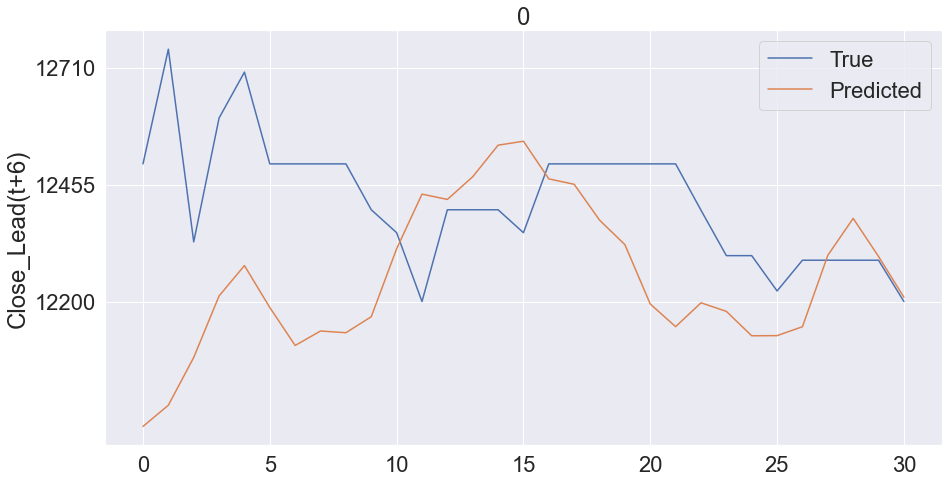

In [597]:
# Plot predictions vs actuals

rows = 22
cols = 1

gbst_fig = prediction_vs_actual_plot(inv_y_test, inv_pred_test)
plt.show()

### RNN & LSTM Model

In [598]:
X_train_enc.shape, y_train_enc.shape, X_test_enc.shape, y_test_enc.shape

((8504, 4041), (8504, 2), (31, 4041), (31, 2))

In [599]:
def stock_index(X_train_enc, X_test_enc):
  TRAIN_INDEX_PER_STOCK = []
  TEST_INDEX_PER_STOCK = []
  for stock in range(1):
    #train
    id_index = len(X_train_enc[X_train_enc[STOCK_ID]==STOCK_IDX])
    TRAIN_INDEX_PER_STOCK.append(id_index)
    # test
    test_id_index = len(X_test_enc[X_test_enc[STOCK_ID]==STOCK_IDX])
    TEST_INDEX_PER_STOCK.append(test_id_index)
  
  return TRAIN_INDEX_PER_STOCK, TEST_INDEX_PER_STOCK

In [600]:
# Indices for train and test
TRAIN_INDEX_PER_STOCK, TEST_INDEX_PER_STOCK = stock_index(X_train_enc, X_test_enc)

In [601]:
# Reshape input to be 3D [samples, timesteps, features]

def reshape_3D(X_train_df, X_test_df):
    train_X = np.empty((1,N_STEPS_IN, int((X_train_df.values.shape[1]-1)/N_STEPS_IN)))
    test_X = np.empty((1,N_STEPS_IN, int((X_test_df.values.shape[1]-1)/N_STEPS_IN)))

    # for each stock
    for stock in range(1):
      # original df for each stock
      stock_df = X_train_df[X_train_df[STOCK_ID]==STOCK_IDX]
      # exclude target column
      stock_df = stock_df.loc[:,[col for col in X_train_df.columns if col != STOCK_ID]]
      # train
      train_X_ = stock_df.values.reshape(stock_df.values.shape[0], N_STEPS_IN, int((stock_df.values.shape[1])/N_STEPS_IN))
      train_X = np.vstack([train_X,train_X_])

      # original df for each stock
      stock_df = X_test_df[X_test_df[STOCK_ID]==STOCK_IDX]
      # exclude target column
      stock_df = stock_df.loc[:,[col for col in X_test_df.columns if col != STOCK_ID]]        
      # test
      test_X_ = stock_df.values.reshape(stock_df.values.shape[0], N_STEPS_IN, int((stock_df.values.shape[1])/N_STEPS_IN))
      test_X = np.concatenate([test_X,test_X_])

    # takeout first element from reshaped beacuse it is just an empty vector
    train_X = np.delete(train_X,0, axis=0)
    test_X = np.delete(test_X,0, axis=0)
    
    print(train_X.shape, test_X.shape)
    
    return train_X, test_X

In [602]:
# Reshape of X train and test to 3D matrix
train_X_reshaped, test_X_reshaped = reshape_3D(X_train_enc, X_test_enc)

(8504, 40, 101) (31, 40, 101)


In [603]:
train_X_reshaped.shape, test_X_reshaped.shape, y_train_enc.shape, y_test_enc.shape

((8504, 40, 101), (31, 40, 101), (8504, 2), (31, 2))

In [604]:
# Function to split per stock 3D reshaped matrix, and predict and test per stock using LSTM

def split_3D_per_stock(df_3D_reshaped, stock_index_list):
  # list of 3D stock arrays
  per_stock_3D_arrays = []
  # list of indexes
  stock_index_list_un = [i for i in stock_index_list]
  # start/end index
  start_index = 0
  end_index = 0
  
  
  for stock in range(1):
    end_index = end_index + stock_index_list_un[stock]    
    stock_reshaped = df_3D_reshaped[start_index:end_index,:,:]    
    per_stock_3D_arrays.append(stock_reshaped)
    start_index += stock_index_list_un[stock]

  return per_stock_3D_arrays  

In [605]:
# Function to train and test RNN/LSTM model

def train_validate_rnn_lstm(train_X_reshaped, test_X_reshaped, y_train_enc, y_test_enc):

  # loss evaluation table
  evaluation_df = pd.DataFrame(columns=['stock_id', 'Train_Loss_Score', 'Validation_Loss_Score'])

  # prediction table 
  prediction_df = pd.DataFrame(columns=[TARGET])

  # val and train loss figure per stock
  fig = plt.figure(figsize=(15,100)) 
  
  # list of 3D shaped inputs per stock with 'split_3D_per_stock' function
  train_X_list_per_stock = split_3D_per_stock(train_X_reshaped, stock_index_list=TRAIN_INDEX_PER_STOCK)
  test_X_list_per_stock = split_3D_per_stock(test_X_reshaped, stock_index_list=TEST_INDEX_PER_STOCK)

  # for each stock
  for stock, x_train in enumerate(train_X_list_per_stock):
    # y train per stock
    train_y = y_train_enc[y_train_enc[STOCK_ID]==STOCK_IDX][TARGET].values
    # y test per stock
    test_y = y_test_enc[y_test_enc[STOCK_ID]==STOCK_IDX][TARGET].values

    # design network
    model = Sequential()
    model.add(Bidirectional(LSTM(30, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # callbacks
    callback1 = ModelCheckpoint(f'best_RNN_stock{STOCK_IDX}.pt', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    #callback2 = EarlyStopping(patience=15, monitor='loss', mode='min')
    callback_list = [callback1]
    
    # fit network
    history = model.fit(x_train, 
                        train_y, 
                        epochs=25, 
                        batch_size=72, 
                        validation_data=(test_X_list_per_stock[stock], test_y), 
                        verbose=2, 
                        #callbacks = callback_list, 
                        shuffle=False)    
    
    # make predictions
    pred = model.predict(test_X_list_per_stock[stock])
    pred = pred.ravel()
    # predictions to DataFrame
    pred_df = pd.DataFrame(pred, columns=[TARGET])
    prediction_df = prediction_df.append(pred_df)
    

    # plot history
    ax1 = fig.add_subplot(rows, cols,(STOCK_IDX+1), title=STOCK_IDX)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')

    #summary table
    data_list = [STOCK_IDX, np.mean(history.history['loss']), np.mean(history.history['val_loss'])]
    evaluation_df.loc[len(evaluation_df), :] = data_list

  return fig, evaluation_df, prediction_df

Train on 8504 samples, validate on 31 samples
Epoch 1/25
 - 5s - loss: 0.0092 - val_loss: 9.3642e-04
Epoch 2/25
 - 4s - loss: 0.0097 - val_loss: 0.0014
Epoch 3/25
 - 3s - loss: 0.0030 - val_loss: 7.7803e-04
Epoch 4/25
 - 3s - loss: 0.0030 - val_loss: 8.2805e-04
Epoch 5/25
 - 4s - loss: 0.0033 - val_loss: 9.5050e-04
Epoch 6/25
 - 4s - loss: 0.0035 - val_loss: 8.5462e-04
Epoch 7/25
 - 4s - loss: 0.0032 - val_loss: 7.6505e-04
Epoch 8/25
 - 4s - loss: 0.0024 - val_loss: 7.3437e-04
Epoch 9/25
 - 4s - loss: 0.0016 - val_loss: 7.6004e-04
Epoch 10/25
 - 4s - loss: 0.0012 - val_loss: 9.2269e-04
Epoch 11/25
 - 4s - loss: 0.0011 - val_loss: 0.0013
Epoch 12/25
 - 3s - loss: 0.0011 - val_loss: 0.0017
Epoch 13/25
 - 3s - loss: 0.0011 - val_loss: 0.0022
Epoch 14/25
 - 3s - loss: 0.0011 - val_loss: 0.0027
Epoch 15/25
 - 3s - loss: 0.0012 - val_loss: 0.0031
Epoch 16/25
 - 3s - loss: 0.0012 - val_loss: 0.0034
Epoch 17/25
 - 3s - loss: 0.0012 - val_loss: 0.0035
Epoch 18/25
 - 3s - loss: 0.0012 - val_loss

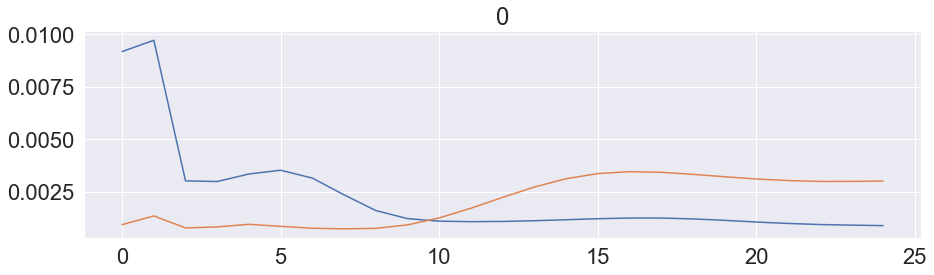

In [606]:
pred_chart, pred_table, predictions_lstm = train_validate_rnn_lstm(train_X_reshaped, test_X_reshaped, y_train_enc, y_test_enc)

In [607]:
pred_table

,stock_id,Train_Loss_Score,Validation_Loss_Score
0,0,0.00226055,0.00207435


In [608]:
# Add stock_id column to prediction 

predictions_lstm[STOCK_ID] = X_test_enc[STOCK_ID].values

In [609]:
# inverse transform lstm predictions
lstm_inv_pred_test = inverse_transform_y(predictions_lstm, scaler_min_scale_zip)

In [610]:
# Evaluation of LSTM test RMSE and Results

# MSE & RMSE score for each stock
lstm_eval_df = evaluate_predictions(inv_y_test, lstm_inv_pred_test)

# add latest close price and stock_id
lstm_eval_df = lstm_eval_df.merge(latest_close, on='stock_id')

# RMSE as % of latest close price
lstm_eval_df['RMSE_%_of_Close'] = lstm_eval_df['RMSE_Score'] / lstm_eval_df['Close']

lstm_eval_df

,stock_id,MSE Score,RMSE_Score,Date,Close,RMSE_%_of_Close
0,0,280157,529.299,2020-08-25,12200.0,0.0433851


In [611]:
gbst_eval_df

,stock_id,MSE Score,RMSE_Score,Date,Close,RMSE_%_of_Close
0,0,38924.6,197.293,2020-08-25,12200.0,0.0161716


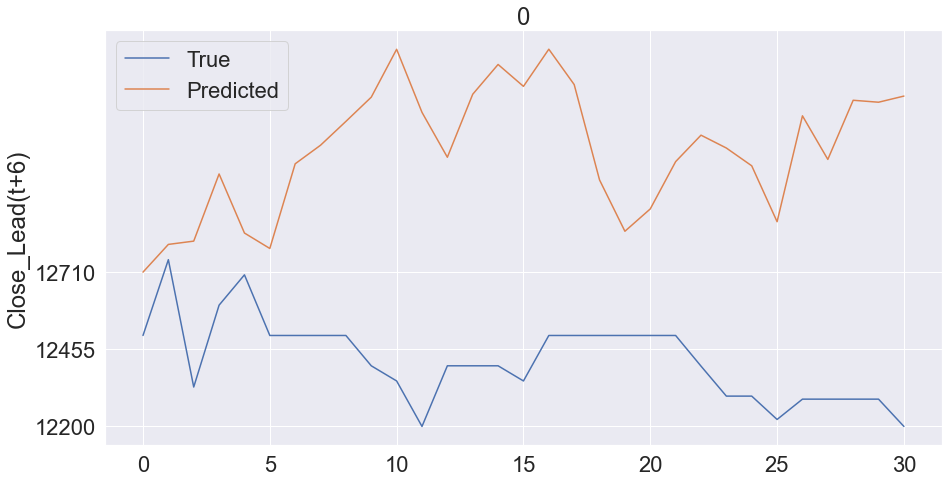

In [612]:
lstm_fig = prediction_vs_actual_plot(inv_y_test, lstm_inv_pred_test)
plt.show()

## Classification Models

#### Data preparation

In [107]:
# Classifcation train and test dataframes
clf_train_df = train_super
clf_test_df = test_super

In [108]:
# Function to add target label column

def add_trading_label(dataframe, y_today_column, y_target_column, min_return, max_loss):
  dataframe['change'] = dataframe[y_target_column] / dataframe[y_today_column] - 1
  
  label_rules = [
    ((min_return > dataframe['change']) & (dataframe['change'] > max_loss)),
    (dataframe['change'] >= min_return),
    (dataframe['change'] <= max_loss)
    ]

  choices = ['Hold', 'Buy', 'Sell']
  
  dataframe['Trading_Decision'] = np.select(label_rules, choices)

  dataframe.drop('change', axis=1, inplace=True) # should I drop this?

  return dataframe

In [109]:
# Add Target label column

MIN_RETURN = 0.02
MAX_LOSS = -0.02
Y_TODAY_COLUMN = 'Close_Lead(t)'
Y_TARGET_COLUMN = 'Close_Lead(t+6)'

train_df_label = add_trading_label(clf_train_df, Y_TODAY_COLUMN, Y_TARGET_COLUMN, MIN_RETURN, MAX_LOSS)
test_df_label = add_trading_label(clf_test_df, Y_TODAY_COLUMN, Y_TARGET_COLUMN, MIN_RETURN, MAX_LOSS)

In [110]:
train_df_label

,Day_id_Lag(t-40),"Close__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)_Lag(t-40)","Close__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)_Lag(t-40)",...,Volume__count_below__t_0_Lead(t+6),"Volume__fft_coefficient__attr_""real""__coeff_0_Lead(t+6)",Volume__range_count__max_1__min_-1_Lead(t+6),Volume__value_count__value_0_Lead(t+6),Change %__percentage_of_reoccurring_values_to_all_values_Lead(t+6),"Volume__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)_Lead(t+6)",Close__max_langevin_fixed_point__m_3__r_30_Lead(t+6),Close_Lead(t+6),stock_id_Lead(t+6),Trading_Decision
40,3,576.031,413.09,1409.27,1178.72,868.403,620.411,1625.98,1539.78,1152.06,...,0.75,564540,3,3,1,215703,4983.62,970,0,Hold
41,4,576.031,413.09,1409.27,1178.72,868.403,620.411,1625.98,1539.78,1152.06,...,0.75,564540,3,3,1,190498,4983.62,970,0,Hold
42,5,576.031,413.09,1409.27,1178.72,868.403,620.411,1621.93,1533.03,1146.76,...,1,0,4,4,1,0,4983.62,970,0,Hold
43,6,576.031,413.09,1405.22,1171.97,863.101,616.565,1610.79,1525.39,1141.3,...,1,0,4,4,1,0,4983.62,970,0,Hold
44,7,570.729,409.244,1394.08,1164.33,857.636,612.69,1595.59,1511,1130.53,...,1,0,4,4,1,0,4983.62,970,0,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539,8502,5975.65,4285.32,14619.6,12227.9,9008.67,6436.04,16867.7,15973.4,11951.3,...,0.25,1.54067e+07,1,1,0.333333,5.46059e+06,4983.62,11999,0,Sell
8540,8503,5975.65,4285.32,14619.6,12227.9,9008.67,6436.04,16874.8,15985.3,11960.6,...,0.5,5.86284e+06,2,2,0.5,2.2209e+06,4983.62,11999,0,Sell
8541,8504,5975.65,4285.32,14626.6,12239.7,9017.94,6442.77,16826.4,15885.6,11881.3,...,0.75,5.43264e+06,3,3,1,1.83318e+06,4983.62,11999,0,Hold
8542,8505,5984.93,4292.06,14578.3,12140,8938.7,6385.13,16699.8,15838.4,11852.4,...,0.75,847400,3,3,0.5,285946,4983.62,11950,0,Hold


In [111]:
train_df_label.groupby('Trading_Decision')['Trading_Decision'].count()

Trading_Decision
Buy     1584
Hold    5509
Sell    1411
Name: Trading_Decision, dtype: int64

In [112]:
test_df_label.groupby('Trading_Decision')['Trading_Decision'].count()

Trading_Decision
Buy      4
Hold    24
Sell     3
Name: Trading_Decision, dtype: int64

In [113]:
# Categorical Encoding

# categorical list assumption
CATEGORICAL_FEATURES = ['Trading_Decision']

train_df_clf = categorical_encoding(train_df_label, CATEGORICAL_FEATURES)
test_df_clf = categorical_encoding(test_df_label, CATEGORICAL_FEATURES)

C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [114]:
# X, y split

# target column 
TARGET = 'Trading_Decision'
TARGET_COLUMN = [TARGET]

STOCK_ID = 'stock_id_Lead(t)'
CURRENT_STOCK_ID_COLUMN = [STOCK_ID]

# Split
X_train_clf, y_train_clf = X_y_split(train_df_label, target_column_list = TARGET_COLUMN, current_column_list=CURRENT_STOCK_ID_COLUMN)
X_test_clf, y_test_clf = X_y_split(test_df_label, target_column_list = TARGET_COLUMN, current_column_list=CURRENT_STOCK_ID_COLUMN)

In [115]:
X_train_clf.shape, X_test_clf.shape, y_train_clf.shape, y_test_clf.shape

((8504, 4041), (31, 4041), (8504, 1), (31, 1))

In [116]:
# Numerical Encoding of X train and test

X_train_clf_enc, X_test_clf_enc, X_clf_scaler_min, X_clf_scaler_scale = encode_numerical_train_transform_test(X_train_clf, X_test_clf)

In [117]:
# return of stock_id column to y_train and y_test to be able to scale per stock
y_train_clf[STOCK_ID] = X_train[STOCK_ID].values
y_test_clf[STOCK_ID] = X_test[STOCK_ID].values

C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
X_train_clf_enc.shape, y_train_clf.shape, X_test_clf_enc.shape, y_test_clf.shape

((8504, 4040), (8504, 2), (31, 4040), (31, 2))

In [119]:
y_train_clf

,Trading_Decision,stock_id_Lead(t)
40,1,0.0
41,1,0.0
42,1,0.0
43,1,0.0
44,1,0.0
...,...,...
8539,2,0.0
8540,2,0.0
8541,1,0.0
8542,1,0.0


#### Classifcation Model - XGBoost Time-Series

In [120]:
# XGBoost Parametars 

import xgboost as xgb

# XGboost Parametars 

booster_param = {'objective':'multi:softmax',
                 'num_class':3,
                 'max_depth':10,
                 'subsample':1,
                 'min_child_weight':0.5,
                 'eta':0.3, 
                 'seed':1,         
                 'eval_metric':'merror'
                 }

print('version:', xgb.__version__, '\n\nBooster Parametars Set')

version: 1.2.1 

Booster Parametars Set


In [123]:
# Function Train/Test/Predict XGboost per Stock

def train_predict_gbst(X_train_enc, y_train_enc_df, X_test_enc):
    # return_df
    prediction_df = pd.DataFrame(columns=[TARGET])
    
    # adding the stock_id column to x_train and x_test to be able to work per stock
    X_train_enc[STOCK_ID] = X_train[STOCK_ID].values
    X_test_enc[STOCK_ID] = X_test[STOCK_ID].values
    
    # adding stock_id column to y_train to be able to work per stock
    y_train_enc_df[STOCK_ID] = X_train_enc[STOCK_ID].values
    
    # for each stock
    for stock in range(1):        
        
        # Train
        # original X_train_enc df for each stock
        stock_df = X_train_enc[X_train_enc[STOCK_ID]==STOCK_IDX]
        # loop through each y
        stock_y_df = y_train_enc_df[y_train_enc_df[STOCK_ID]==STOCK_IDX]              
        # xgboost Matrix
        xgb_train = xgb.DMatrix(stock_df.values, stock_y_df['Trading_Decision'].values, )
        # xgboost Train
        bst = xgb.train(booster_param, xgb_train, num_boost_round=1000)
        
        # Test
        # original X_test_enc df for each stock
        test_stock_df = X_test_enc[X_test_enc[STOCK_ID]==STOCK_IDX]
        # xgboost Matrix
        X_test_xgb = xgb.DMatrix(test_stock_df.values)
        # xgboost Predict
        pred = bst.predict(X_test_xgb)
        # predictions to DataFrame
        pred_df = pd.DataFrame(pred, columns=TARGET_COLUMN)
        prediction_df = prediction_df.append(pred_df)
                
    return prediction_df

In [124]:
# Train & Predict the Test with XGboost

clf_predictions = train_predict_gbst(X_train_clf_enc, y_train_clf, X_test_clf_enc)

C:\Users\vladimir\anaconda3\envs\py369\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [125]:
# Add stock_id column to prediction 

clf_predictions[STOCK_ID] = X_test_clf_enc[STOCK_ID].values

In [126]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_test_clf.iloc[:,0].astype('float32'), clf_predictions.iloc[:,0])
accuracy

0.7741935483870968

In [127]:
conf_mtrx = metrics.confusion_matrix(y_test_clf.iloc[:,0].astype('float32'), clf_predictions.iloc[:,0])
conf_mtrx

array([[ 0,  4,  0],
       [ 0, 24,  0],
       [ 0,  3,  0]], dtype=int64)

# Work in Progress






In [ ]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp